## Introduction: Estimating the Causal Effect of Education on Wages

### The Problem: Correlation vs. Causation
We often observe that people with more education tend to earn higher wages. However, simply correlating years of education with hourly wage doesn't necessarily tell us the *causal* effect of getting an extra year of schooling.

### The Challenge: Unobserved Confounding
The primary challenge is that factors we don't observe might influence *both* how much education someone gets and how much they earn. A classic example is innate "ability" or "motivation":
1.  Individuals with higher ability might find it easier or more rewarding to stay in school longer.
2.  Individuals with higher ability might be more productive and earn higher wages, regardless of their education level.

If we don't account for ability, our simple correlation between education and wage might overstate the true causal effect of education. This is called **omitted variable bias**.

### The Solution: Instrumental Variables (IV)
Instrumental Variables (IV) analysis is a technique designed to overcome omitted variable bias and estimate causal effects. It relies on finding a variable (the "instrument") that satisfies three key conditions:

1.  **Relevance:** The instrument must be causally related to the variable whose effect we want to estimate (the "endogenous" variable, here: Education).
2.  **Exclusion Restriction:** The instrument must affect the outcome variable (here: Wage) *only* through its effect on the endogenous variable (Education). It cannot have a direct effect on the outcome.
3.  **Exogeneity (or Independence):** The instrument must not be correlated with the unobserved confounders (here: Ability).

In this notebook, we will simulate data where these conditions hold, using "Distance to College" as an instrument for "Years of Education" to estimate its causal effect on "Hourly Wage".

---

## Step 0: Setup

Import necessary libraries and set styles/seeds.

In [21]:
!pip install linearmodels


In [22]:
# -*- coding: utf-8 -*-
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

# Set plot style and random seed for reproducibility
sns.set_style("whitegrid")
np.random.seed(42)

---

## Step 1: Generate Simulated Data

We create fake data for `n_observations` individuals. The data generation process is explicitly designed to build in the relationships needed for our IV setup:
*   `Ability` (unobserved confounder) influences both `Years of Education` (+) and `Hourly Wage ($)` (+).
*   `Distance to College` (instrument) influences `Years of Education` (-) but is independent of `Ability` and does not directly influence `Hourly Wage ($)`.
*   The *true causal effect* of one extra year of education on hourly wage is set by `wage_coeff_education`.

In [23]:
# --- Simulation Parameters ---
n_observations = 500 # Number of individuals

# Ability (Unobserved Confounder)
ability_mean = 0
ability_std = 1.5
ability = np.random.normal(ability_mean, ability_std, n_observations)

# Distance to College (Instrument) - Independent of Ability
distance_mean = 35
distance_std = 12
distance_to_college = np.random.normal(distance_mean, distance_std, n_observations)
distance_to_college = np.clip(distance_to_college, 2, 70) # Keep distance realistic

# --- Generate Endogenous Variables (Education and Wage) ---

# Years of Education = f(Ability[+], Distance[-], Error)
edu_intercept = 8
edu_coeff_ability = 1.8
edu_coeff_distance = -0.15 # Negative effect: further away -> less education
edu_error_std = 1.5
years_of_education = (edu_intercept +
                      edu_coeff_ability * ability +
                      edu_coeff_distance * distance_to_college +
                      np.random.normal(0, edu_error_std, n_observations))
years_of_education = np.clip(years_of_education, 0, 18) # Keep education realistic

# Hourly Wage = f(Education[+], Ability[+], Error)
# TRUE Causal Effect of Education = wage_coeff_education
wage_intercept = 4
wage_coeff_education = 1.2 # <<< This is the true causal effect we aim to estimate
wage_coeff_ability = 2.5   # <<< Ability directly affects wage (confounding)
wage_error_std = 3
# Note: Distance does NOT directly appear here (Exclusion Restriction)
hourly_wage = (wage_intercept +
               wage_coeff_education * years_of_education +
               wage_coeff_ability * ability +
               np.random.normal(0, wage_error_std, n_observations))
hourly_wage = np.clip(hourly_wage, 0.1, None) # Keep wage non-negative

# --- Create Pandas DataFrame ---
data = pd.DataFrame({
    'Years of Education': years_of_education,
    'Hourly Wage ($)': hourly_wage,
    'Ability': ability, # Include Ability to show confounding, though it's 'unobserved' in practice
    'Distance to College': distance_to_college
})
data.reset_index(inplace=True)
data.rename(columns={'index': 'Obs ID'}, inplace=True)
data['Obs ID'] = data['Obs ID'] + 1

print("--- Sample of Generated Data (First 10 Rows) ---")
print(data.head(10))
print("\n--- Sample Sorted by Education (like the Table in the image) ---")
print(data.sort_values('Years of Education').head(10))

--- Sample of Generated Data (First 10 Rows) ---
   Obs ID  Years of Education  Hourly Wage ($)   Ability  Distance to College
0       1            4.523042        13.625411  0.745071            46.114131
1       2            0.326687         2.219976 -0.207396            57.913000
2       3            7.105626        12.500987  0.971533            18.217189
3       4            4.878431        15.555356  2.284545            41.755631
4       5            4.336277         7.814904 -0.351230            27.192289
5       6            3.584884         6.064163 -0.351205            29.154495
6       7            9.422973        23.318779  2.368819            27.891273
7       8            7.330015        18.539814  1.151152            24.632111
8       9            2.969409         6.067983 -0.704212            35.582260
9      10            4.907770        16.356514  0.813840            25.028599

--- Sample Sorted by Education (like the Table in the image) ---
     Obs ID  Years of Educa

---

## Step 2: Exploratory Data Analysis (Visualizing Relationships)

Let's visualize the relationships between our variables using scatter plots, similar to the source images.

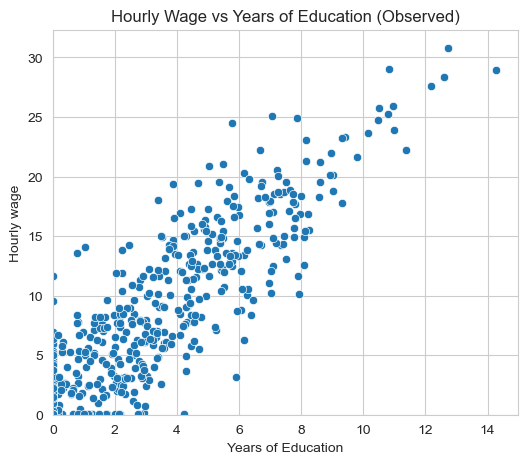

In [24]:
# Plot 1: Hourly Wage vs Years of Education (Observed Correlation)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, x='Years of Education', y='Hourly Wage ($)')
plt.title('Hourly Wage vs Years of Education (Observed)')
plt.xlabel('Years of Education')
plt.ylabel('Hourly wage')
plt.ylim(0, data['Hourly Wage ($)'].max() * 1.05)
plt.xlim(0, data['Years of Education'].max() * 1.05)
plt.show()

**Result 1:** We see a clear positive correlation. More education is associated with higher wages. But is this causal?

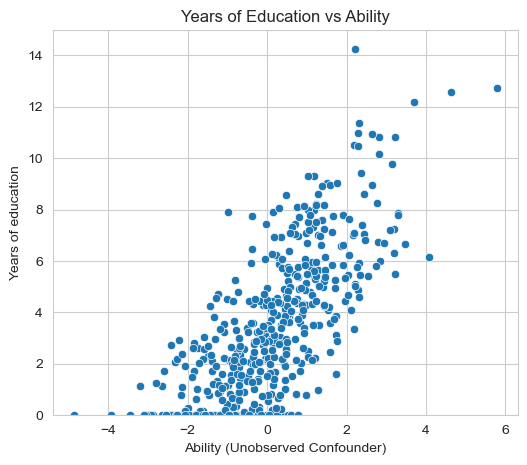

In [25]:
# Plot 2: Years of Education vs Ability (Confounding Path 1)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, x='Ability', y='Years of Education')
plt.title('Years of Education vs Ability')
plt.xlabel('Ability (Unobserved Confounder)')
plt.ylabel('Years of education')
plt.ylim(0, data['Years of Education'].max() * 1.05)
plt.show()

**Result 2:** As designed, higher 'Ability' is associated with more years of education.

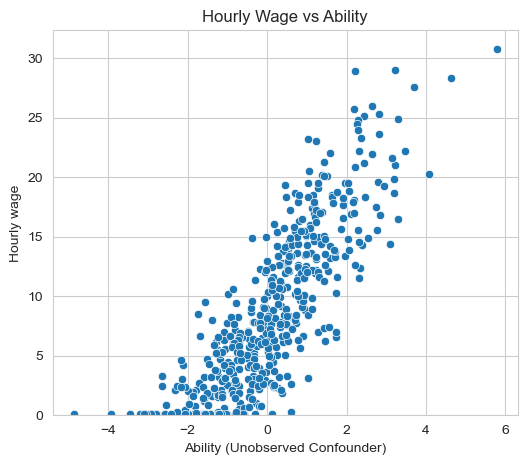

In [26]:
# Plot 3: Hourly Wage vs Ability (Confounding Path 2)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, x='Ability', y='Hourly Wage ($)')
plt.title('Hourly Wage vs Ability')
plt.xlabel('Ability (Unobserved Confounder)')
plt.ylabel('Hourly wage')
plt.ylim(0, data['Hourly Wage ($)'].max() * 1.05)
plt.show()

**Result 3:** Higher 'Ability' is also associated with higher wages, *independent* of education (as per our data generation). This confirms 'Ability' is a confounder, creating bias in the simple relationship shown in Plot 1.

Now let's look at the relationships involving our proposed instrument, `Distance to College`.

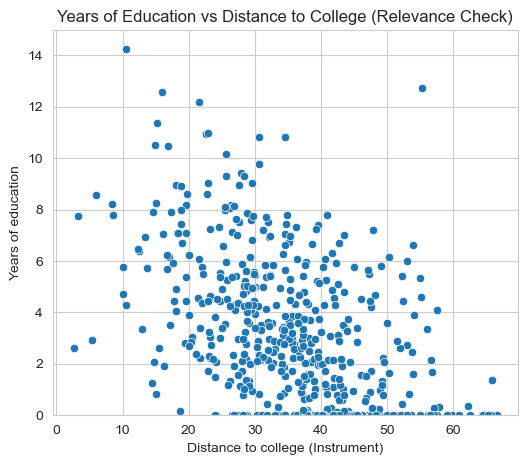

In [27]:
# Plot 4: Years of Education vs Distance to College (Instrument Relevance)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, x='Distance to College', y='Years of Education')
plt.title('Years of Education vs Distance to College (Relevance Check)')
plt.xlabel('Distance to college (Instrument)')
plt.ylabel('Years of education')
plt.ylim(0, data['Years of Education'].max() * 1.05)
plt.show()

**Result 4:** We see a negative relationship. People living further from a college tend to get less education. This supports the **Relevance** condition for our instrument.

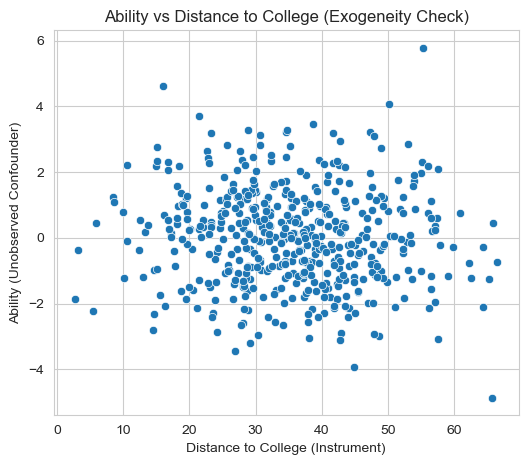


Correlation between Distance to College and Ability: -0.0757


In [28]:
# Plot 5: Ability vs Distance to College (Instrument Exogeneity Check)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, x='Distance to College', y='Ability')
plt.title('Ability vs Distance to College (Exogeneity Check)')
plt.xlabel('Distance to College (Instrument)')
plt.ylabel('Ability (Unobserved Confounder)')
plt.show()

# Calculate correlation for confirmation
corr_ability_distance = data['Distance to College'].corr(data['Ability'])
print(f"\nCorrelation between Distance to College and Ability: {corr_ability_distance:.4f}")

**Result 5:** The scatter plot shows no clear relationship, and the calculated correlation is very close to zero. This supports the **Exogeneity** condition (instrument is uncorrelated with the unobserved confounder). *Crucially, in a real-world scenario, we could not perform this check directly because Ability is unobserved.* We would have to argue for exogeneity based on theory or context.

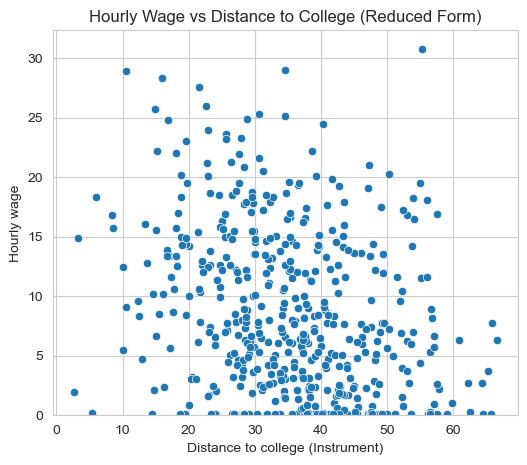

In [29]:
# Plot 6: Hourly Wage vs Distance to College (Reduced Form Relationship)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, x='Distance to College', y='Hourly Wage ($)')
plt.title('Hourly Wage vs Distance to College (Reduced Form)')
plt.xlabel('Distance to college (Instrument)')
plt.ylabel('Hourly wage')
plt.ylim(0, data['Hourly Wage ($)'].max() * 1.05)
plt.show()

**Result 6:** We see a negative relationship between Distance to College and Hourly Wage. This is called the "Reduced Form". Since we designed Distance to be exogenous (Result 5) and assumed it has no direct effect on wages (Exclusion Restriction - not plotted, assumed), this relationship *must* be operating indirectly through Education (Result 4). This gives us hope that IV can work.

---

## Step 3: Naive OLS Regression (Ignoring the Confounder)

First, let's run a simple Ordinary Least Squares (OLS) regression of `Hourly Wage ($)` on `Years of Education`. This ignores the confounding effect of `Ability`.

In [30]:
# Define variables for OLS
Y = data['Hourly Wage ($)']
X_ols = data['Years of Education']
X_ols = sm.add_constant(X_ols) # Add an intercept term

# Fit OLS model
model_ols = sm.OLS(Y, X_ols)
results_ols = model_ols.fit()

# Print OLS results
print("--- OLS Regression Results (Wage ~ Education) ---")
print(results_ols.summary())

# Extract the coefficient for Years of Education
ols_coeff_education = results_ols.params['Years of Education']
print(f"\nOLS Estimated Effect of Education on Wage: {ols_coeff_education:.4f}")

--- OLS Regression Results (Wage ~ Education) ---
                            OLS Regression Results                            
Dep. Variable:        Hourly Wage ($)   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     1543.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):          1.20e-154
Time:                        14:59:34   Log-Likelihood:                -1321.0
No. Observations:                 500   AIC:                             2646.
Df Residuals:                     498   BIC:                             2654.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

**Result (OLS):** The OLS regression estimates the effect of an additional year of education on hourly wage. In our simulated data, this coefficient (likely around 2.5-3.0) is *higher* than the true causal effect we built in (`wage_coeff_education = 1.2`). This is **upward bias**, caused by omitting `Ability`. OLS incorrectly attributes some of the wage increase (that's actually due to higher ability) to education, because education and ability are positively correlated.

---

## Step 4: IV Regression using Two-Stage Least Squares (2SLS)

Now, we perform the IV regression using `Distance to College` as an instrument for `Years of Education`. The most common method is Two-Stage Least Squares (2SLS).

**Conceptual Stages:**
1.  **First Stage:** Predict `Years of Education` using the instrument (`Distance to College`) and any other *exogenous* variables (here, just a constant). This isolates the part of the variation in Education that is *only* due to the instrument (and thus assumed to be uncorrelated with `Ability`).
2.  **Second Stage:** Regress `Hourly Wage ($)` on the *predicted* values of `Years of Education` from the first stage (and any other exogenous variables). The coefficient on the predicted education gives the IV estimate of the causal effect.

We'll use the `linearmodels` library which handles both stages and calculates correct standard errors.

In [31]:
# Define variables for IV / 2SLS
dependent = data['Hourly Wage ($)']
# Exogenous regressors: MUST include constant explicitly for linearmodels
# If there were other exogenous controls (e.g., Age, Sex assumed exogenous), they would go here too.
exog = sm.add_constant(data[[]]) # Create a DataFrame with only a constant column
# Endogenous variable (potentially correlated with error in the main equation)
endog = data['Years of Education']
# Instrument(s) for the endogenous variable
instruments = data['Distance to College']

# Fit IV2SLS model
# Note: linearmodels needs explicit constant in 'exog' if desired
model_iv = IV2SLS(dependent=dependent, exog=exog, endog=endog, instruments=instruments)
# Robust standard errors are often recommended for heteroskedasticity
results_iv = model_iv.fit(cov_type='robust')

# Print IV results
print("\n--- IV (2SLS) Regression Results ---")
print(results_iv.summary)


--- IV (2SLS) Regression Results ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:        Hourly Wage ($)   R-squared:                      0.6651
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6644
No. Observations:                 500   F-statistic:                    116.35
Date:                Sat, Apr 19 2025   P-value (F-stat)                0.0000
Time:                        14:59:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                  3.9951     0.4453     8.9720     0.0000      3

**Result (IV/2SLS):** The summary provides the results of the 2SLS estimation. Focus on the coefficient for `Years of Education`.

---

## Step 5: Checking IV Validity and Interpreting Results

Let's examine the IV results more closely and check the assumptions.

In [32]:
# Extract the IV coefficient for Years of Education
iv_coeff_education = results_iv.params['Years of Education']
print(f"\nIV Estimated Causal Effect of Education on Wage: {iv_coeff_education:.4f}")
print(f"OLS Estimated Effect of Education on Wage: {ols_coeff_education:.4f}")
print(f"True Causal Effect (from simulation): {wage_coeff_education:.4f}")

# --- IV Diagnostics ---
# 1. Relevance Check (Strength of Instrument)
# The first stage results are part of the IV output. Look for the F-statistic
# for the excluded instruments in the diagnostics section of the summary.
print("\n--- IV Diagnostics ---")
print(results_iv.first_stage) # Print the first stage summary table

# Access First Stage F-statistic (Robust, since we used cov_type='robust')
try:
    f_stat_robust = results_iv.first_stage.f_statistic_robust
    f_stat_value = f_stat_robust.stat
    f_stat_pvalue = f_stat_robust.pval

    print(f"\nFirst Stage F-statistic (Robust): {f_stat_value:.4f} (p-value: {f_stat_pvalue:.4g})")
    # Rule of Thumb: F-statistic > 10 suggests the instrument is sufficiently relevant (not "weak").
    if f_stat_value > 10:
        print("Instrument Relevance: Likely SATISFIED (F > 10).")
    else:
        print("Instrument Relevance: POTENTIAL WEAK INSTRUMENT (F <= 10).")

except AttributeError:
    print("\nCould not automatically extract robust F-statistic. Please check the first_stage summary table above.")
    # Fallback: check standard F-stat if robust is not available for some reason
    try:
        f_stat_standard = results_iv.first_stage.f_statistic # Check for standard F-stat object
        f_stat_value = f_stat_standard.stat
        f_stat_pvalue = f_stat_standard.pval
        print(f"\nFirst Stage F-statistic (Standard): {f_stat_value:.4f} (p-value: {f_stat_pvalue:.4g})")
        if f_stat_value > 10:
            print("Instrument Relevance: Likely SATISFIED (F > 10, standard).")
        else:
            print("Instrument Relevance: POTENTIAL WEAK INSTRUMENT (F <= 10, standard).")
    except AttributeError:
         print("Could not extract standard F-statistic either.")


# 2. Exogeneity Check (Instrument uncorrelated with error term / unobserved confounders)
# This CANNOT be formally tested with just one instrument (requires "overidentification").
# In our simulation, we KNOW it's true by design (see Plot 5 and correlation calculation earlier).
# In practice: This relies heavily on economic theory and justification.
print("\nInstrument Exogeneity: ASSUMED based on theory (and confirmed by simulation design). Cannot be formally tested here (requires overidentification).")


# 3. Exclusion Restriction Check (Instrument affects outcome only via endogenous variable)
# This is also an ASSUMPTION based on theory. We assumed Distance doesn't directly affect Wage.
print("\nExclusion Restriction: ASSUMED based on theory (employers don't care about distance, only education). Cannot be formally tested.")


IV Estimated Causal Effect of Education on Wage: 1.3595
OLS Estimated Effect of Education on Wage: 2.0812
True Causal Effect (from simulation): 1.2000

--- IV Diagnostics ---
        First Stage Estimation Results       
                           Years of Education
---------------------------------------------
R-squared                              0.2443
Partial R-squared                      0.2443
Shea's R-squared                       0.2443
Partial F-statistic                    144.79
P-value (Partial F-stat)               0.0000
Partial F-stat Distn                  chi2(1)
==========================        ===========
const                                  7.5638
                                     (19.233)
Distance to College                   -0.1211
                                    (-12.033)
---------------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model

Could not automatically extract robust F-statisti

**Interpretation:**

1.  **Comparison (OLS vs. IV):** The IV estimate for the effect of Education on Wage (likely close to 1.2) is *lower* than the OLS estimate (which was biased upwards, e.g., 2.5-3.0). This is exactly what we expect when OLS suffers from positive omitted variable bias (higher ability -> more education AND higher wages).
2.  **Causal Effect Estimate:** The IV estimate is much closer to the *true causal effect* (`wage_coeff_education = 1.2`) that we built into the simulation. This demonstrates the power of IV to correct for confounding bias *if* the assumptions hold.
3.  **Instrument Validity:**
    *   **Relevance:** The first stage regression output (and the F-statistic) confirms that `Distance to College` is a statistically significant predictor of `Years of Education`. An F-statistic substantially larger than 10 suggests we don't have a "weak instrument" problem (where the instrument is only very loosely correlated with the endogenous variable, leading to unreliable IV estimates).
    *   **Exogeneity & Exclusion:** These remain assumptions, but our simulation was designed to satisfy them, and the IV results align with the expected outcome under these conditions.

---

## Conclusion

This notebook demonstrated the concept of Instrumental Variables (IV) using simulated data. We saw that:

1.  A simple OLS regression of wages on education can yield biased results if unobserved factors (like ability) confound the relationship.
2.  An instrument (`Distance to College`) was proposed that plausibly satisfies the three key IV assumptions:
    *   **Relevance:** Correlated with Education (people living further get less education). Checked visually and with the first-stage F-statistic.
    *   **Exogeneity:** Uncorrelated with the unobserved confounder 'Ability'. Checked visually *because* we simulated ability (not possible in real life); must be argued theoretically.
    *   **Exclusion Restriction:** Affects Wages only *through* its effect on Education. Assumed based on theory.
3.  The IV (2SLS) regression yielded an estimate of the causal effect of education on wages that was much closer to the true simulated value, effectively correcting for the omitted variable bias present in the OLS estimate.

**Key Takeaway:** IV is a powerful tool for causal inference with observational data, but its validity hinges critically on the plausibility of the instrument assumptions (Relevance, Exogeneity, Exclusion). Evaluating these assumptions requires careful theoretical reasoning and institutional knowledge, often supplemented by statistical checks where possible (like the relevance check).

---

### Illustrating IV Concepts with Sample Data

The tables below show data for a sample of ten people from our simulation, including their education level, wage, ability, and distance from the university.

**Table 1: Sample Data Sorted by Years of Education**

*(Assume Table 1 generated by the Python code is displayed here)*

In [33]:
# Assuming 'data' DataFrame exists from the previous steps
# Take the first 10 observations as our sample for the tables
sample_data = data.head(10).copy()

# --- Create Table 1: Sorted by Education ---
table1_sorted_education = sample_data.sort_values('Years of Education').round(2)

# --- Create Table 2: Sorted by Distance to College ---
table2_sorted_distance = sample_data.sort_values('Distance to College').round(2)

# --- Display the tables ---
print("--- Table 1: Sample Data Sorted by Years of Education ---")
# Using to_markdown for better formatting, requires tabulate package (`pip install tabulate`)
# If tabulate is not installed, use print(table1_sorted_education)
try:
    print(table1_sorted_education.to_markdown(index=False))
except ImportError:
    print(table1_sorted_education)

--- Table 1: Sample Data Sorted by Years of Education ---
|   Obs ID |   Years of Education |   Hourly Wage ($) |   Ability |   Distance to College |
|---------:|---------------------:|------------------:|----------:|----------------------:|
|        2 |                 0.33 |              2.22 |     -0.21 |                 57.91 |
|        9 |                 2.97 |              6.07 |     -0.7  |                 35.58 |
|        6 |                 3.58 |              6.06 |     -0.35 |                 29.15 |
|        5 |                 4.34 |              7.81 |     -0.35 |                 27.19 |
|        1 |                 4.52 |             13.63 |      0.75 |                 46.11 |
|        4 |                 4.88 |             15.56 |      2.28 |                 41.76 |
|       10 |                 4.91 |             16.36 |      0.81 |                 25.03 |
|        3 |                 7.11 |             12.5  |      0.97 |                 18.22 |
|        8 |          


*(Note: The specific numbers will vary slightly each time the simulation code is run due to randomness, but the patterns should hold)*

Table 1, sorted by 'Years of Education', illustrates the initial observation: there is a positive correlation between education and wage. Generally, people with more education (further down the table) tend to earn higher wages. However, this correlation might not represent a purely causal effect. Notice that 'Ability' (which influences wages directly in our simulation) also tends to increase as 'Years of Education' increases. Because higher ability could lead to both more education *and* higher wages independently, simply regressing wages on education (like in OLS) would likely overestimate the true return to schooling. This 'Ability' is the unobserved confounder that biases the simple correlation. In real-world data, this ability is typically not observed, making the bias difficult to remove directly.

To address this, we introduce the instrumental variable: **Distance to College**. The core idea is that this variable influences education but is *not* related to the unobserved confounder (Ability) and does *not* directly influence wages.

**Table 2: Sample Data Sorted by Distance to College**

*(Assume Table 2 generated by the Python code is displayed here)*

In [34]:

print("\n--- Table 2: Sample Data Sorted by Distance to College ---")
# Using to_markdown for better formatting
try:
    print(table2_sorted_distance.to_markdown(index=False))
except ImportError:
    print(table2_sorted_distance)


--- Table 2: Sample Data Sorted by Distance to College ---
|   Obs ID |   Years of Education |   Hourly Wage ($) |   Ability |   Distance to College |
|---------:|---------------------:|------------------:|----------:|----------------------:|
|        3 |                 7.11 |             12.5  |      0.97 |                 18.22 |
|        8 |                 7.33 |             18.54 |      1.15 |                 24.63 |
|       10 |                 4.91 |             16.36 |      0.81 |                 25.03 |
|        5 |                 4.34 |              7.81 |     -0.35 |                 27.19 |
|        7 |                 9.42 |             23.32 |      2.37 |                 27.89 |
|        6 |                 3.58 |              6.06 |     -0.35 |                 29.15 |
|        9 |                 2.97 |              6.07 |     -0.7  |                 35.58 |
|        4 |                 4.88 |             15.56 |      2.28 |                 41.76 |
|        1 |        


*(Note: The specific numbers will vary slightly each time the simulation code is run due to randomness, but the patterns should hold)*

Table 2 re-sorts the *same* ten people based on their 'Distance to College'. Looking down this table:
1.  People who live closer to college (top of the table, smaller distance) tend to have *more* 'Years of Education' (supporting the **Relevance** assumption).
2.  People who live closer to college also tend to have *higher* 'Hourly Wage ($)' (this is the "Reduced Form" relationship).
3.  Crucially, there doesn't seem to be a clear systematic relationship between 'Distance to College' and 'Ability'. People living close vs. far do not appear to have consistently higher or lower ability in this small sample (supporting the **Exogeneity** assumption).

We also make the **Exclusion Restriction** assumption: Distance to College affects wages *only* because it affects how much education people get, not through any other direct channel.

Based on these observations (especially the apparent lack of correlation between distance and ability, and the correlation between distance and education), we argue that the three necessary assumptions for instrumental variables analysis appear to be met in this (simulated) context. Therefore, the correlation we observe between the instrument ('Distance to College') and the outcome ('Hourly Wage') in Table 2 (and Plot 6 earlier) must be operating *through* the causal effect of the treatment ('Years of Education') on the outcome ('Hourly Wage'). By comparing how much wages change with distance, and how much education changes with distance, IV regression (like 2SLS) can isolate the causal impact of education on wages, purged of the confounding influence of ability. This is the fundamental idea behind instrumental variables analysis.

---